In [48]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

In [49]:
# Use Otsu's thresholding to determine blocksize and number of iterations
def otsuSize(imgName):
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold using value calculated by Otsu's Binarization
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Remove noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(blur,cv2.MORPH_OPEN,kernel, iterations=2)

    plt.subplot(1, 2, 1), plt.imshow(gray, 'gray')
    plt.title('Original')
    plt.subplot(1, 2, 2), plt.imshow(thresh, 'gray')
    # Title shows threshold value calculated using Otsu's
    plt.title('Threshold ' + str(ret))
    plt.show()

    output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    stats = output[2]
    count = output[0] - 1 # background doesn't count as a scale
    
    # calculate average size of scales detected using Otsu's thresholding
    avgScaleSize = np.average(stats[1:,-1])
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    avgScaleSizeProportion = avgScaleSize / totalPixels
    # divide average scale size by total pixels because every image has different total number of pixels, and
    # we want to know the relative size of the scales in proportion to the size of the entire image
    
    print(avgScaleSizeProportion)
    maxScaleSize = max(stats[1:,-1])
    maxScaleSizeProportion = maxScaleSize / totalPixels
    print(maxScaleSizeProportion)
    
    # large ventral scales
    if maxScaleSizeProportion > 0.15 and maxScaleSizeProportion < 0.35:
        blockSize = 85
        iterations = 3
    # small scales
    elif avgScaleSizeProportion < 0.01:
        blockSize = 15
        iterations = 1
    # medium sized scales, or extremely large scales (probably scales blended together)
    elif avgScaleSizeProportion < 0.035 or avgScaleSizeProportion > 0.2:
        blockSize = 25
        iterations = 2
    # large scales
    else:
        blockSize = 45
        iterations = 2
        
    countScales(imgName, blockSize, iterations)

In [42]:
def countScales(imgName, blockSize, openingIterations=2):   
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # blur and adaptive thresholding
    # source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
    blur = cv2.GaussianBlur(gray,(5,5),0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize, -2)

    # Remove noise by opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=openingIterations)
    
    # Check if opening was too much
    numWhitePixels = cv2.countNonZero(opening) # number of foreground pixels
    totalPixels = img.size / 3 # not sure why it has to be divided by 3
    if numWhitePixels / totalPixels < 0.2:
        # if opening resulted in less than 30% foreground, decrease number of opening iterations
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,kernel, iterations=1)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    output = cv2.connectedComponentsWithStats(sure_fg, 8, cv2.CV_32S)
    labels = output[1]
    count = output[0] - 1 # background doesn't count as a scale
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    stats = output[2]
    avgScaleSize = np.average(stats[1:,-1])
    avgScaleSizeProportion = avgScaleSize / totalPixels
    minScaleSize = min(stats[1:,-1])
    minScaleSizeProportion = minScaleSize / totalPixels
    #print(avgScaleSizeProportion)
    #print(minScaleSizeProportion)
    
    if avgScaleSizeProportion > 0.01:
        for i in range(1, labels.max()):
            scaleAreaProportion = stats[i, cv2.CC_STAT_AREA] / totalPixels
            if scaleAreaProportion < 0.002:
                count -= 1
    
    #roundnessList = []
    # calculate average roundness of detected scales
    #for i in range(1, count + 1): # start at 1 instead of 0 because don't want to count background as a scale
        #scaleArea = stats[i, cv2.CC_STAT_AREA]
        #boxArea = stats[i, cv2.CC_STAT_WIDTH] * stats[i, cv2.CC_STAT_HEIGHT]
        #roundnessList.append(scaleArea / boxArea)
    #avgRoundness = sum(roundnessList) / len(roundnessList)
    
    # if roundess is too low, do adaptive threshoding again using a smaller blocksize (unless blocksize is already really small)
    #if avgRoundness < 0.7 and blockSize > 15:
        #countScales(imgName, blockSize - 20, openingIterations)
    if True:
        # display final results
        print('Blocksize: ' + str(blockSize))
        print('Number of iterations: ' + str(openingIterations))
        plt.subplot(1, 5, 1), plt.imshow(gray, 'gray')
        plt.title('Original')
        
        plt.subplot(1, 5, 2), plt.imshow(thresh, 'gray')
        plt.title('Threshold')
        
        plt.subplot(1, 5, 3), plt.imshow(opening, 'gray')
        plt.title('Opening')
        
        plt.subplot(1, 5, 4), plt.imshow(sure_fg, 'gray')
        plt.title('Sure fg')
        
        plt.subplot(1, 5, 5), plt.imshow(labeled_img, 'gray')
        plt.title('Count: ' + str(count))
        plt.show()

212019Ventral-NoFlash-3.png


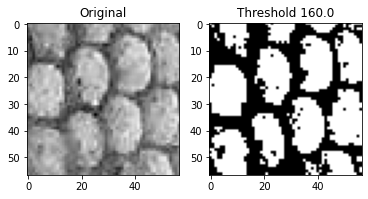

0.024810309526677104
0.07017543859649122
Blocksize: 25
Number of iterations: 2


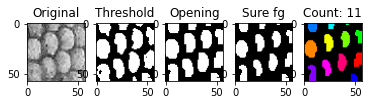

212019Dorsal-NoFlash-2.png


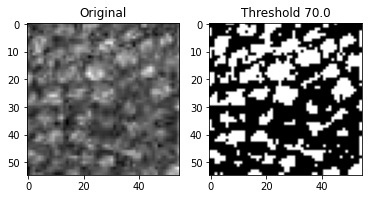

0.005939393939393939
0.10181818181818182
Blocksize: 15
Number of iterations: 1


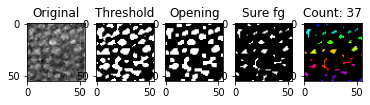

251165Ventral-NoFlash-2.png


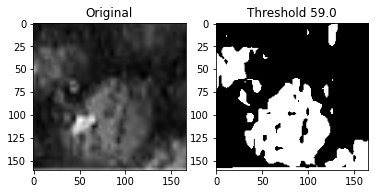

0.024658248378127894
0.2526355421686747
Blocksize: 85
Number of iterations: 3


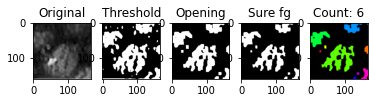

251165Ventral-Flash-3.png


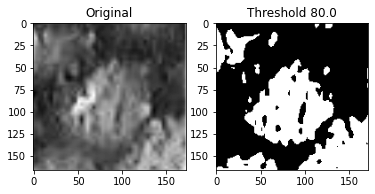

0.026513028859624546
0.18440039226674138
Blocksize: 85
Number of iterations: 3


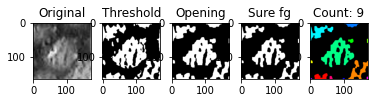

212018Dorsal-NoFlash-3.png


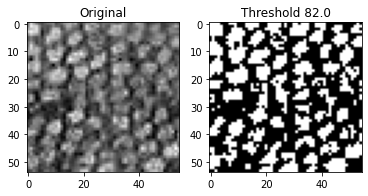

0.007682889501071319
0.03535353535353535
Blocksize: 15
Number of iterations: 1


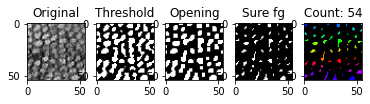

212018Dorsal-NoFlash-2.png


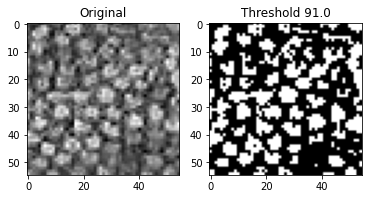

0.006226798536783634
0.04925619834710744
Blocksize: 15
Number of iterations: 1


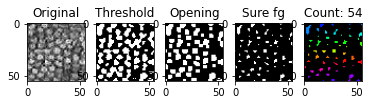

214993Dorsal-NoFlash-1.png


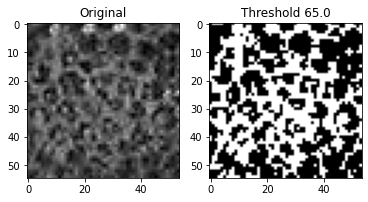

0.021885521885521887
0.428956228956229
Blocksize: 25
Number of iterations: 2


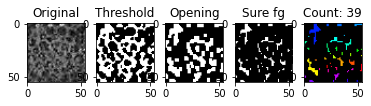

251165Ventral-Flash-2.png


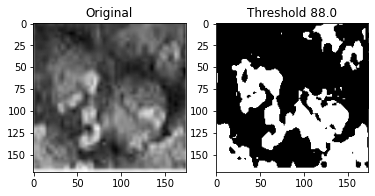

0.016047858423729314
0.32853279242731576
Blocksize: 85
Number of iterations: 3


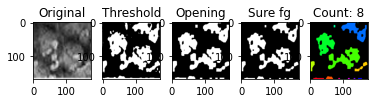

251165Ventral-NoFlash-3.png


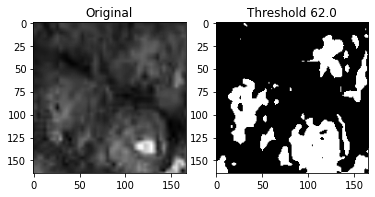

0.009236131517941686
0.10428298560094035
Blocksize: 15
Number of iterations: 1


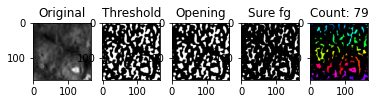

212019Dorsal-NoFlash-3.png


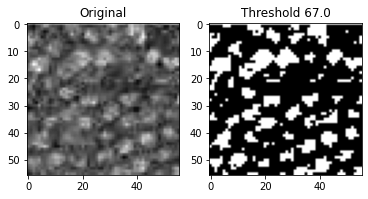

0.004788390766142523
0.03826530612244898
Blocksize: 15
Number of iterations: 1


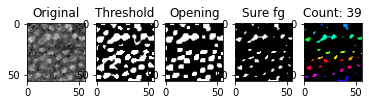

212019Ventral-NoFlash-2.png


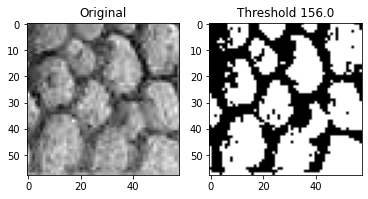

0.03097815883346893
0.20392390011890607
Blocksize: 85
Number of iterations: 3


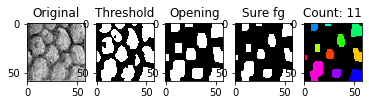

212019Dorsal-NoFlash-1.png


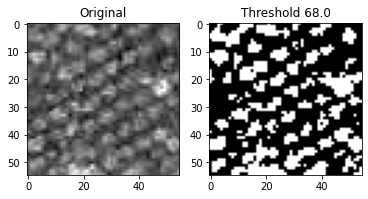

0.006341096919609317
0.03570247933884298
Blocksize: 15
Number of iterations: 1


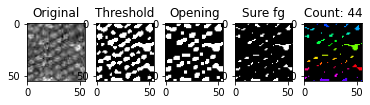

251165Ventral-NoFlash-1.png


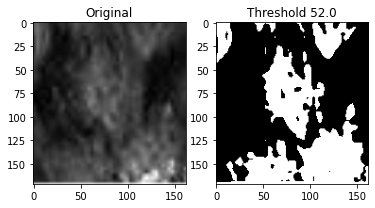

0.026524240187030885
0.18988659201837496
Blocksize: 85
Number of iterations: 3


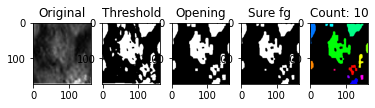

214993Dorsal-NoFlash-3.png


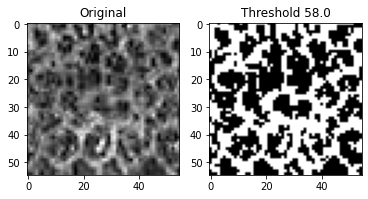

0.028118619348565875
0.36793388429752066
Blocksize: 25
Number of iterations: 2


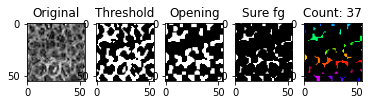

212018Dorsal-NoFlash-1.png


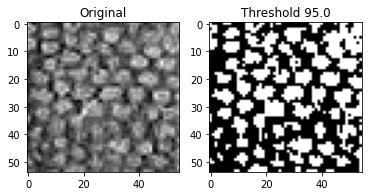

0.007915518824609733
0.05016835016835017
Blocksize: 15
Number of iterations: 1


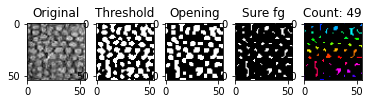

214993Dorsal-NoFlash-2.png


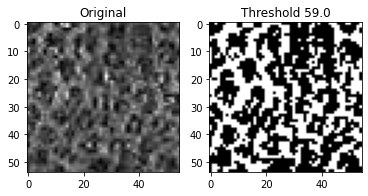

0.013678451178451179
0.20336700336700336
Blocksize: 85
Number of iterations: 3


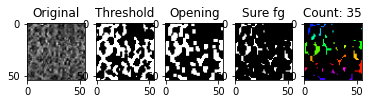

251165Ventral-Flash-1.png


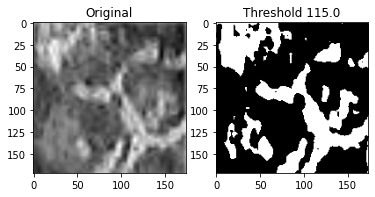

0.014326808583023497
0.13602646351242983
Blocksize: 25
Number of iterations: 2


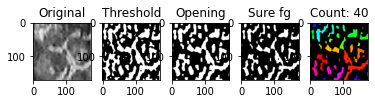

212019Ventral-NoFlash-1.png


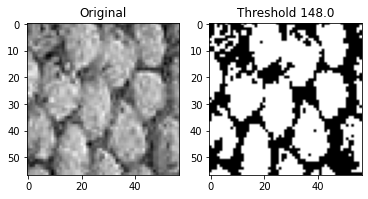

0.0357576086759727
0.45583256386580484
Blocksize: 45
Number of iterations: 2


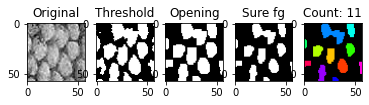

226121Dorsal-NoFlash-2.png


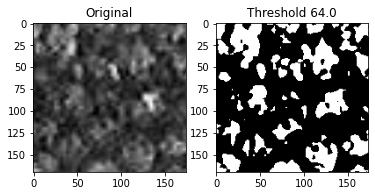

0.005387546868277092
0.0389790398918188
Blocksize: 15
Number of iterations: 1


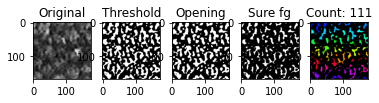

226123Dorsal-NoFlash-1.png


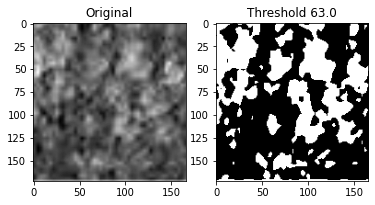

0.010585197934595525
0.1733678901653124
Blocksize: 85
Number of iterations: 3


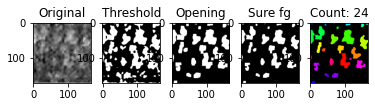

226121Dorsal-NoFlash-3.png


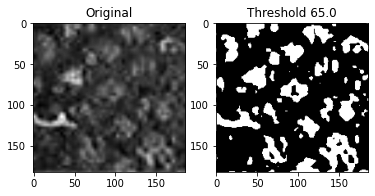

0.0036751673374064266
0.03343967860096892
Blocksize: 15
Number of iterations: 1


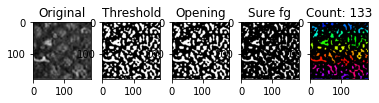

226121Dorsal-NoFlash-1.png


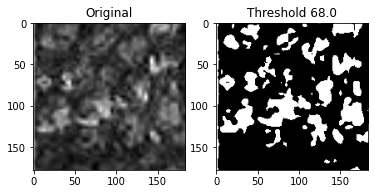

0.005709574987787005
0.036944308744504155
Blocksize: 15
Number of iterations: 1


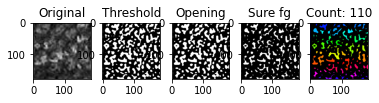

226123Dorsal-NoFlash-2.png


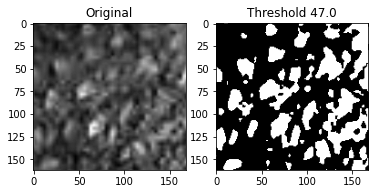

0.0060709294199860235
0.058017342739564964
Blocksize: 15
Number of iterations: 1


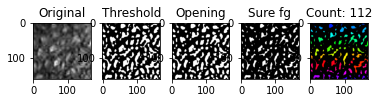

226123Dorsal-NoFlash-3.png


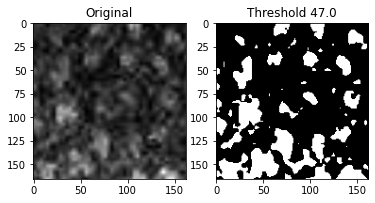

0.004355302953203327
0.04592443849471962
Blocksize: 15
Number of iterations: 1


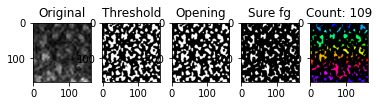

214993Ventral-Flash-3.png


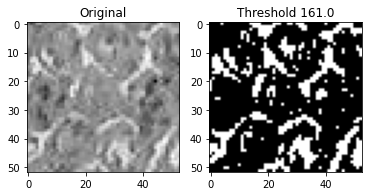

0.003962494528532264
0.02539912917271408
Blocksize: 15
Number of iterations: 1


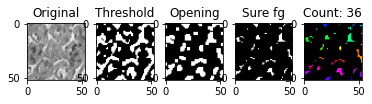

226123Dorsal-Flash-2.png


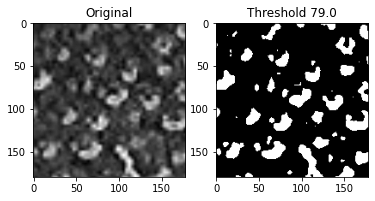

0.0032091581951132512
0.01348314606741573
Blocksize: 15
Number of iterations: 1


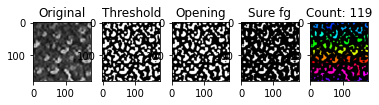

212018Ventral-NoFlash-1.png


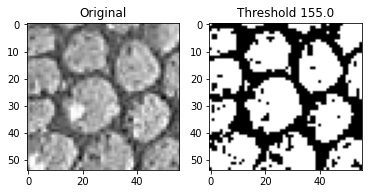

0.032372598162071844
0.0958994708994709
Blocksize: 25
Number of iterations: 2


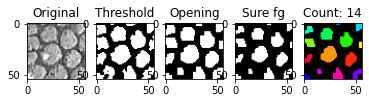

226123Dorsal-Flash-3.png


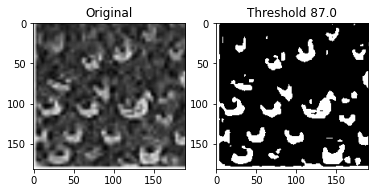

0.004983352351773405
0.05902255639097744
Blocksize: 15
Number of iterations: 1


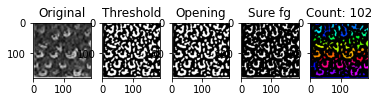

251165Dorsal-NoFlash-1.png


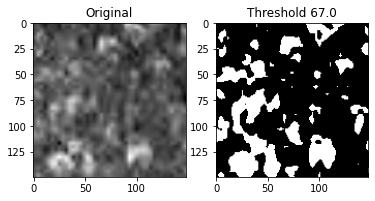

0.00563984438984439
0.09378378378378378
Blocksize: 15
Number of iterations: 1


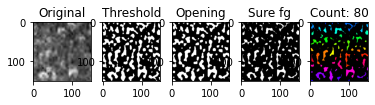

212020Ventral-NoFlash-1.png


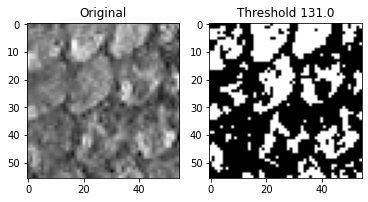

0.00752716671084018
0.04902597402597403
Blocksize: 15
Number of iterations: 1


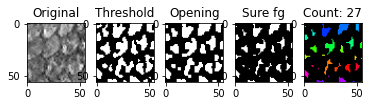

214993Ventral-Flash-2.png


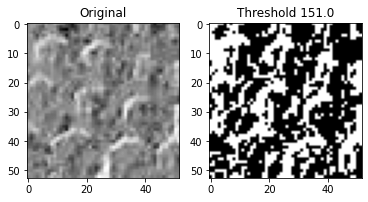

0.009094781346627123
0.10050798258345428
Blocksize: 15
Number of iterations: 1


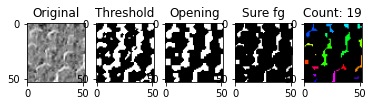

212020Ventral-NoFlash-3.png


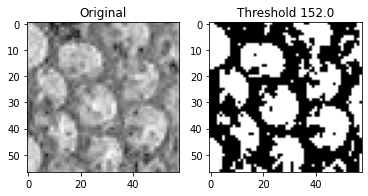

0.014793179068360557
0.08015728977616456
Blocksize: 25
Number of iterations: 2


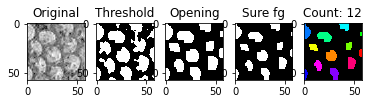

226123Dorsal-NoFlash-4.png


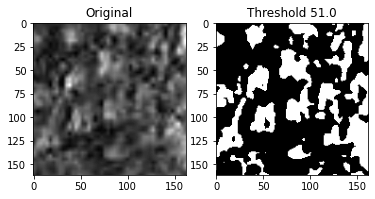

0.008485456016320213
0.06938728852309099
Blocksize: 15
Number of iterations: 1


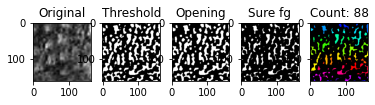

251165Dorsal-NoFlash-3.png


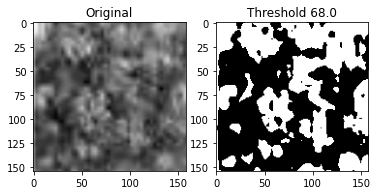

0.01763110307414105
0.19640802235738944
Blocksize: 85
Number of iterations: 3


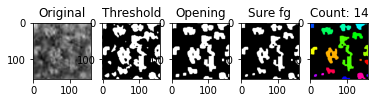

226123Dorsal-Flash-1.png


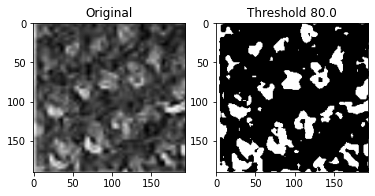

0.0035645159984127118
0.0361096039066739
Blocksize: 15
Number of iterations: 1


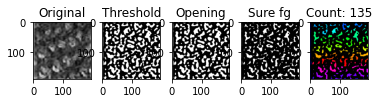

212018Ventral-NoFlash-3.png


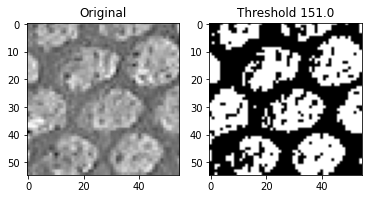

0.021397445529676935
0.07504132231404959
Blocksize: 25
Number of iterations: 2


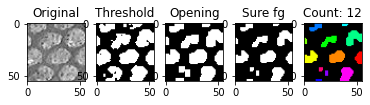

212018Ventral-NoFlash-2.png


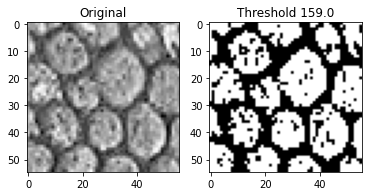

0.03453017570664629
0.11006493506493506
Blocksize: 25
Number of iterations: 2


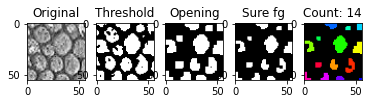

251165Dorsal-NoFlash-2.png


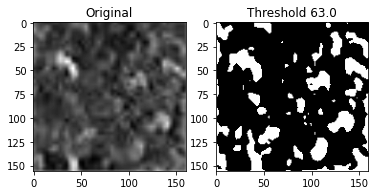

0.00490145935624659
0.029487179487179487
Blocksize: 15
Number of iterations: 1


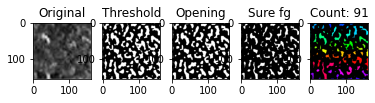

212020Ventral-NoFlash-2.png


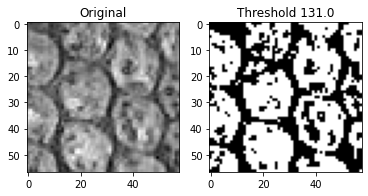

0.03487420376499057
0.19540229885057472
Blocksize: 85
Number of iterations: 3


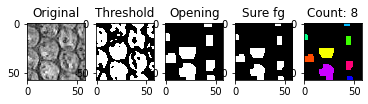

214993Ventral-Flash-1.png


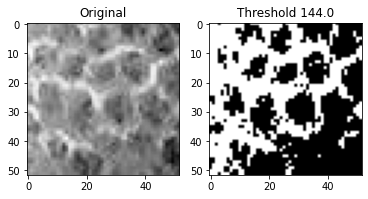

0.027258092586146882
0.4426775147928994
Blocksize: 25
Number of iterations: 2


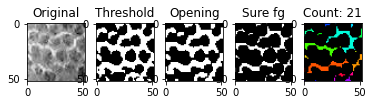

226123Ventral-Flash-3.png


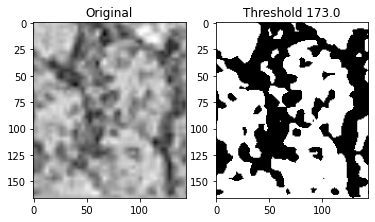

0.03477636034333412
0.45548862115127176
Blocksize: 25
Number of iterations: 2


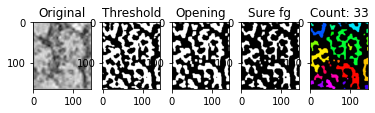

212020Dorsal-NoFlash-3.png


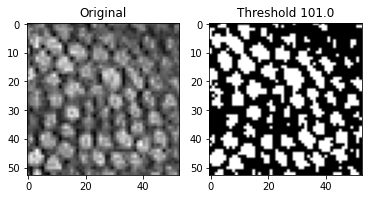

0.005423743010910309
0.04058383766464934
Blocksize: 15
Number of iterations: 1


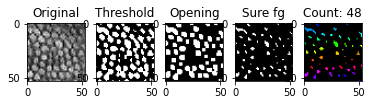

212020Dorsal-NoFlash-2.png


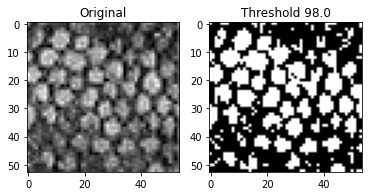

0.006080707573244887
0.13487071977638015
Blocksize: 15
Number of iterations: 1


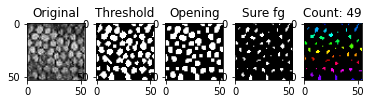

226123Ventral-Flash-2.png


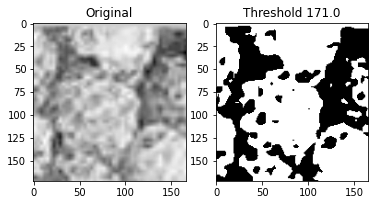

0.052127113103577094
0.5580694872513309
Blocksize: 45
Number of iterations: 2


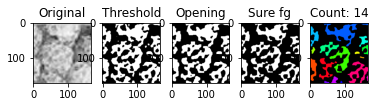

212020Dorsal-NoFlash-1.png


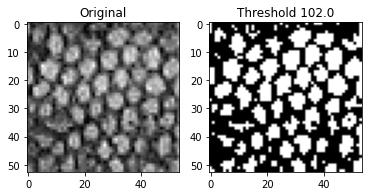

0.006616876310272537
0.0660377358490566
Blocksize: 15
Number of iterations: 1


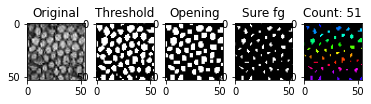

226123Ventral-Flash-1.png


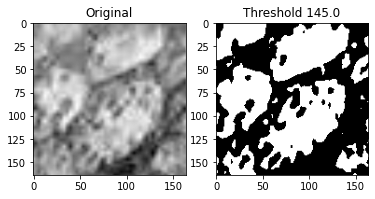

0.016187801040087504
0.16028405710886376
Blocksize: 85
Number of iterations: 3


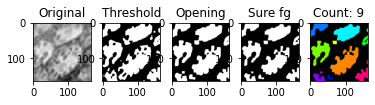

226121Ventral-NoFlash-3.png


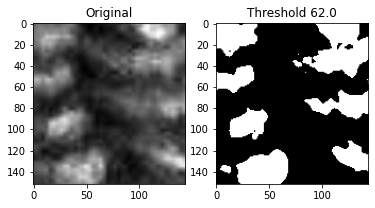

0.02683738425925926
0.0885873538011696
Blocksize: 25
Number of iterations: 2


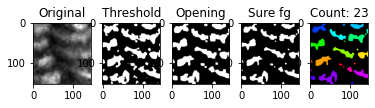

212010Ventral-NoFlash-2.png


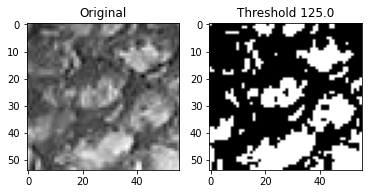

0.008738425925925926
0.1283068783068783
Blocksize: 15
Number of iterations: 1


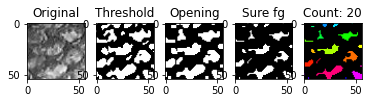

212010Ventral-NoFlash-3.png


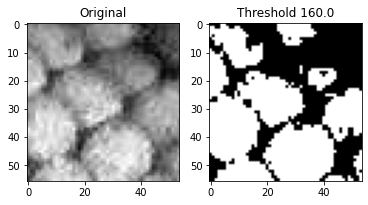

0.07279265873015874
0.5251322751322751
Blocksize: 45
Number of iterations: 2


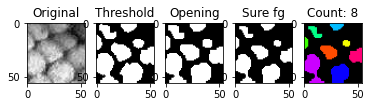

226121Ventral-NoFlash-2.png


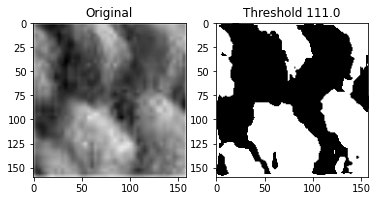

0.1625263713080169
0.4873417721518987
Blocksize: 45
Number of iterations: 2


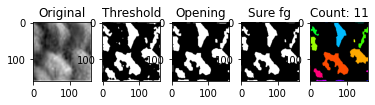

212010Ventral-NoFlash-1.png


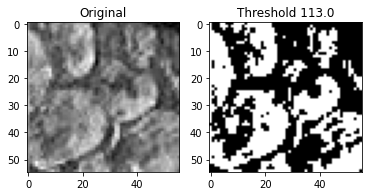

0.020553359683794466
0.14253246753246754
Blocksize: 25
Number of iterations: 2


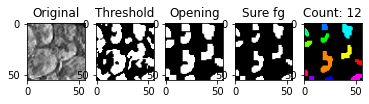

226121Ventral-NoFlash-1.png


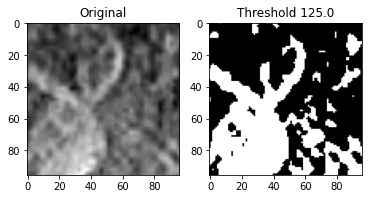

0.018263691603535352
0.3121744791666667
Blocksize: 85
Number of iterations: 3


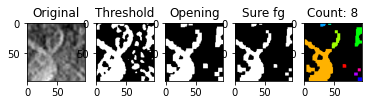

214993Ventral-NoFlash-1.png


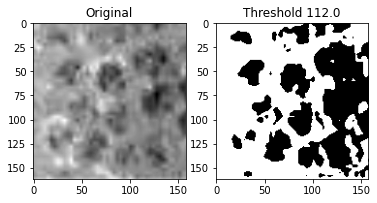

0.07802977027660572
0.611540865760275
Blocksize: 45
Number of iterations: 2


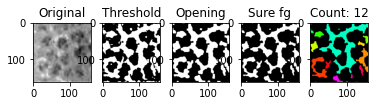

214993Ventral-NoFlash-3.png


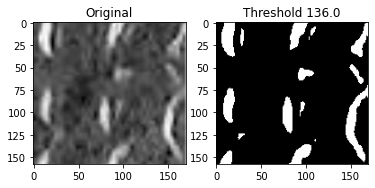

0.008982377761231074
0.04411764705882353
Blocksize: 15
Number of iterations: 1


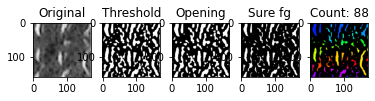

214993Ventral-NoFlash-2.png


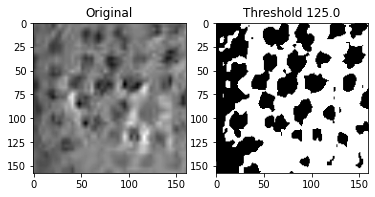

0.07552412974683544
0.596242088607595
Blocksize: 45
Number of iterations: 2


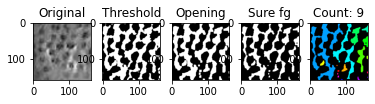

In [50]:
dirName = 'Anolis_cristatellus_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)

In [ ]:
dirName = 'More_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)

S5.PNG


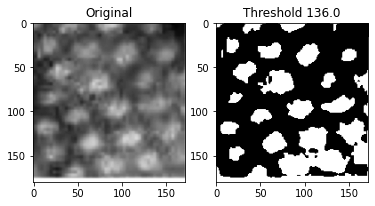

0.01871052253804192
0.16498708010335916
Blocksize: 85
Number of iterations: 2


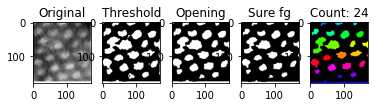

S4.png


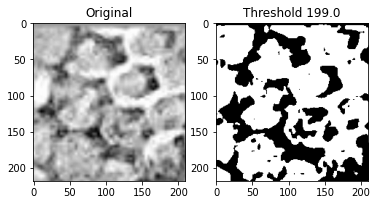

0.09502277975410348
0.6564657055482743
Blocksize: 45
Number of iterations: 2


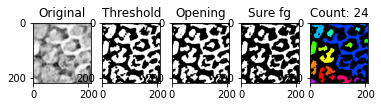

S1.png


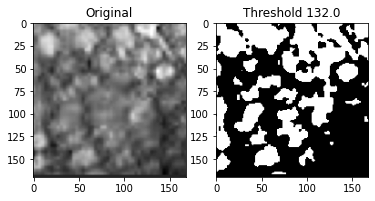

0.014158163265306122
0.14450280112044817
Blocksize: 25
Number of iterations: 2


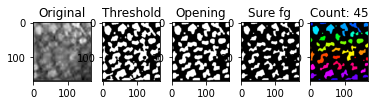

S3.png


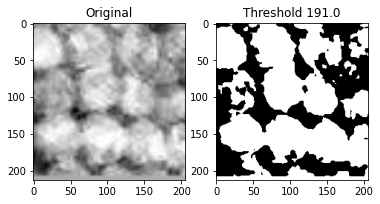

0.04653219101836065
0.33451639494412894
Blocksize: 85
Number of iterations: 2


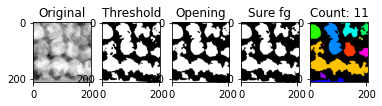

S2.png


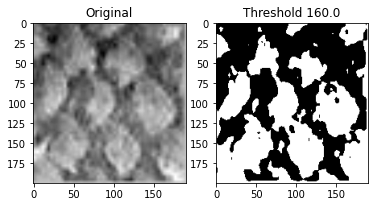

0.023606516290726815
0.24644736842105264
Blocksize: 85
Number of iterations: 2


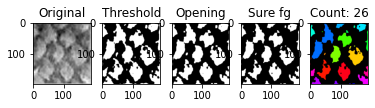

In [74]:
dirName = 'Scale_images'
for img in os.scandir(dirName):
    if img.name != '.DS_Store': #not sure why, but there's some invisible .DS_Store files in this folder
        print(img.name)
        otsuSize(dirName + "/" + img.name)

257349_ventral-5-.png


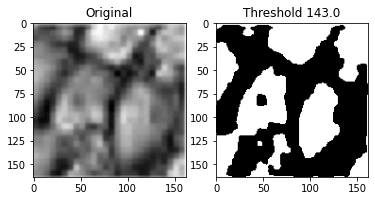

0.0576586495031617
0.18108250526949715
Blocksize: 85
Number of iterations: 2


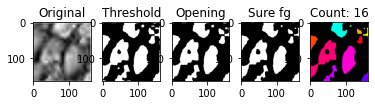

135164_D-3-.png.png


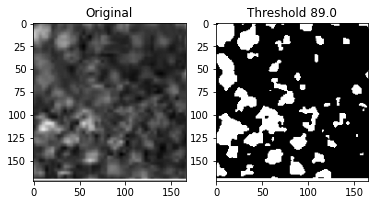

0.0051934228318735
0.029840291398150743
Blocksize: 15
Number of iterations: 1


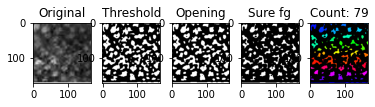

Screenshot 2020-11-16 at 4.15.13 PM.png


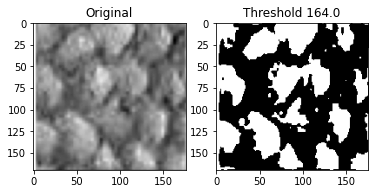

0.014191867969758437
0.08957219251336898
Blocksize: 25
Number of iterations: 2


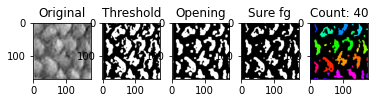

235180_ventral-4-.png


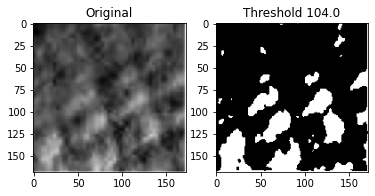

0.0091753334296307
0.10783499446290144
Blocksize: 15
Number of iterations: 1


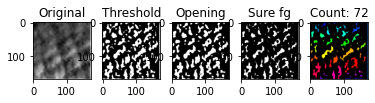

257349_ventral-4-.png


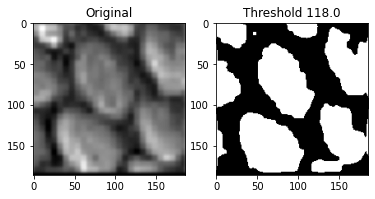

0.05689482406443905
0.12096774193548387
Blocksize: 45
Number of iterations: 2


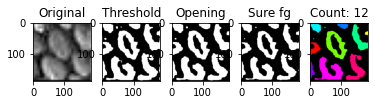

Screenshot 2020-11-16 at 4.15.23 PM.png


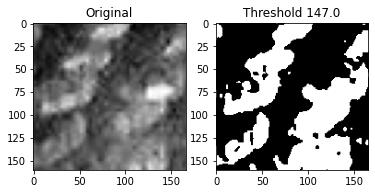

0.023021251673360107
0.2135542168674699
Blocksize: 85
Number of iterations: 2


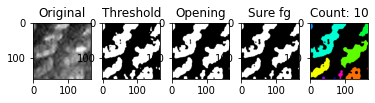

Screenshot 2020-11-16 at 5.00.35 PM.png


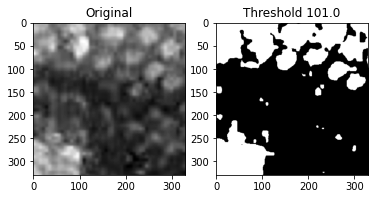

0.016304866850321394
0.21211202938475665
Blocksize: 85
Number of iterations: 2


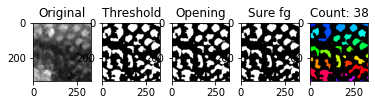

257349_ventral-3-.png


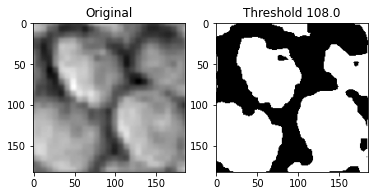

0.08605948582907108
0.28524164008034975
Blocksize: 85
Number of iterations: 2


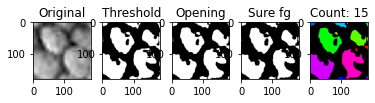

235180_ventral-3-.png


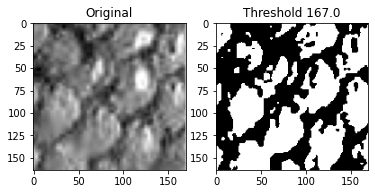

0.02225375834321003
0.3173601147776184
Blocksize: 85
Number of iterations: 2


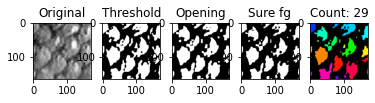

135164_D.png-5-.png


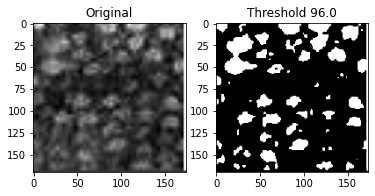

0.003635960924203213
0.03123732251521298
Blocksize: 15
Number of iterations: 1


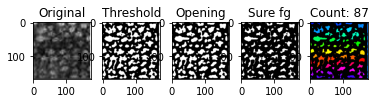

135164_D.png-4-.png


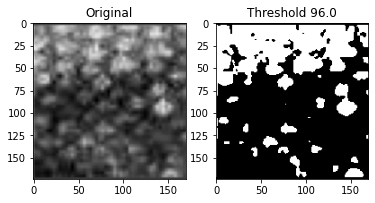

0.011841083815390778
0.2420554428668019
Blocksize: 85
Number of iterations: 2


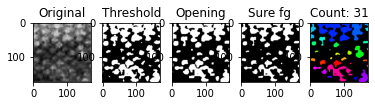

Screenshot 2020-11-16 at 4.15.34 PM.png


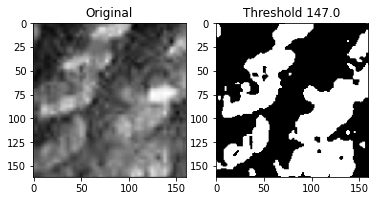

0.026203221450617285
0.22064043209876544
Blocksize: 85
Number of iterations: 2


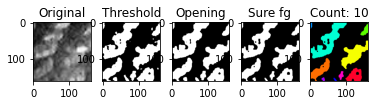

big_img.png


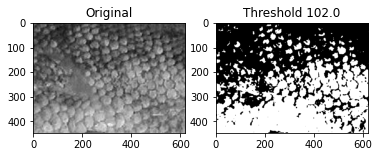

0.0028489962892508844
0.40626080069124426
Blocksize: 15
Number of iterations: 1


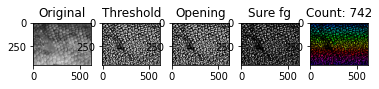

135164_D-7-.png


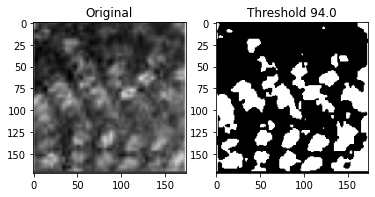

0.010160945408765986
0.06886527666399359
Blocksize: 25
Number of iterations: 2


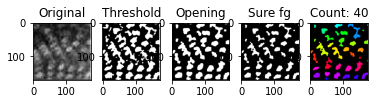

135164_D-6-.png


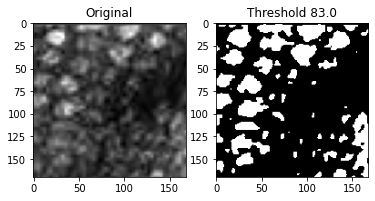

0.0043969282628305555
0.029411764705882353
Blocksize: 15
Number of iterations: 1


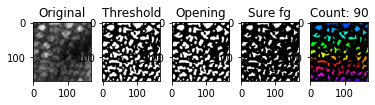

135164_D-2.png.png


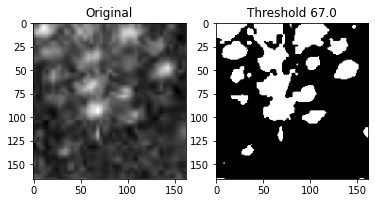

0.011240730116232124
0.1121523129555258
Blocksize: 25
Number of iterations: 2


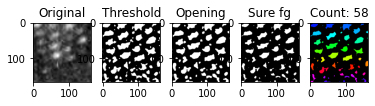

257349_ventral.png


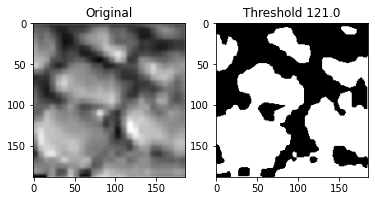

0.11043239533287577
0.2556909174102036
Blocksize: 85
Number of iterations: 2


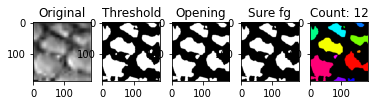

In [75]:
dirName = 'grouped_images'
for img in os.scandir(dirName):
    print(img.name)
    otsuSize(dirName + "/" + img.name)